In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.6585406 , -0.7525452 , -0.69864213], dtype=float32)

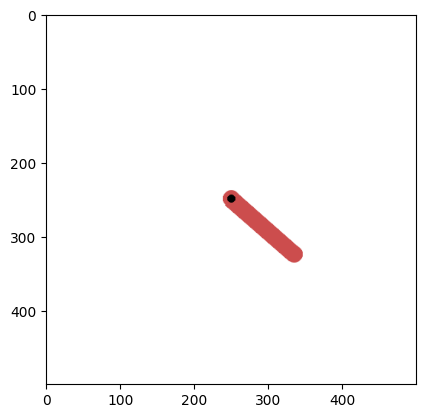

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch
import random
from IPython import display


#定义模型
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc_statu = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
        )

        self.fc_mu = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Tanh(),
        )

        self.fc_std = torch.nn.Sequential(
            torch.nn.Linear(128, 1),
            torch.nn.Softplus(),
        )

    def forward(self, state):
        state = self.fc_statu(state)

        mu = self.fc_mu(state) * 2.0
        std = self.fc_std(state)

        return mu, std


class PPO:

    def __init__(self):
        #定义模型
        self.model = Model()

        self.model_td = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
        )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.optimizer_td = torch.optim.Adam(self.model_td.parameters(),
                                             lr=5e-3)
        self.loss_fn = torch.nn.MSELoss()

    def get_action(self, state):
        state = torch.FloatTensor(state).reshape(1, 3)
        mu, std = self.model(state)

        #根据概率选择一个动作
        #action = random.normalvariate(mu=mu.item(), sigma=std.item())
        action = torch.distributions.Normal(mu, std).sample().item()

        return action

    def get_data(self):
        states = []
        rewards = []
        actions = []
        next_states = []
        overs = []

        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = self.get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action])

            #记录数据样本
            states.append(state)
            rewards.append(reward)
            actions.append(action)
            next_states.append(next_state)
            overs.append(over)

            #更新游戏状态,开始下一个动作
            state = next_state

        #[b, 3]
        states = torch.FloatTensor(states).reshape(-1, 3)
        #[b, 1]
        rewards = torch.FloatTensor(rewards).reshape(-1, 1)
        #[b, 1]
        actions = torch.FloatTensor(actions).reshape(-1, 1)
        #[b, 3]
        next_states = torch.FloatTensor(next_states).reshape(-1, 3)
        #[b, 1]
        overs = torch.LongTensor(overs).reshape(-1, 1)

        return states, rewards, actions, next_states, overs

    def test(self, play):
        #初始化游戏
        state = env.reset()

        #记录反馈值的和,这个值越大越好
        reward_sum = 0

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = self.get_action(state)

            #执行动作,得到反馈
            state, reward, over, _ = env.step([action])
            reward_sum += reward

            #打印动画
            if play and random.random() < 0.2:  #跳帧
                display.clear_output(wait=True)
                show()

        return reward_sum

    #优势函数
    def get_advantages(self, deltas):
        advantages = []

        #反向遍历deltas
        s = 0.0
        for delta in deltas[::-1]:
            s = 0.9 * 0.9 * s + delta
            advantages.append(s)

        #逆序
        advantages.reverse()
        return advantages
    
    def train(self, states, rewards, actions, next_states, overs):
        #偏移reward,便于训练
        rewards = (rewards + 8) / 8

        #计算values和targets
        #[b, 3] -> [b, 1]
        values = self.model_td(states)

        #[b, 3] -> [b, 1]
        targets = self.model_td(next_states).detach()
        targets = targets * 0.98
        targets *= (1 - overs)
        targets += rewards

        #计算优势,这里的advantages有点像是策略梯度里的reward_sum
        #只是这里计算的不是reward,而是target和value的差
        #[b, 1]
        deltas = (targets - values).squeeze(dim=1).tolist()
        advantages = self.get_advantages(deltas)
        advantages = torch.FloatTensor(advantages).reshape(-1, 1)

        #取出每一步动作的概率
        #[b, 3] -> [b, 1],[b, 1]
        mu, std = self.model(states)
        #[b, 1]
        old_probs = torch.distributions.Normal(mu, std)
        old_probs = old_probs.log_prob(actions).exp().detach()

        #每批数据反复训练10次
        for _ in range(10):
            #重新计算每一步动作的概率
            #[b, 3] -> [b, 1],[b, 1]
            mu, std = self.model(states)
            #[b, 1]
            new_probs = torch.distributions.Normal(mu, std)
            new_probs = new_probs.log_prob(actions).exp()

            #求出概率的变化
            #[b, 1] - [b, 1] -> [b, 1]
            ratios = new_probs / old_probs

            #计算截断的和不截断的两份loss,取其中小的
            #[b, 1] * [b, 1] -> [b, 1]
            surr1 = ratios * advantages
            #[b, 1] * [b, 1] -> [b, 1]
            surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages

            loss = -torch.min(surr1, surr2)
            loss = loss.mean()

            #重新计算value,并计算时序差分loss
            values = self.model_td(states)
            loss_td = self.loss_fn(values, targets)

            #更新参数
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.optimizer_td.zero_grad()
            loss_td.backward()
            self.optimizer_td.step()


teacher = PPO()

teacher.train(*teacher.get_data())

teacher.get_action([1, 2, 3]), teacher.test(play=False)

/tmp/ipykernel_18402/3166162692.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.FloatTensor(states).reshape(-1, 3)


(-0.04278993606567383, -1636.4170616846322)

In [4]:
for i in range(6000):
    teacher.train(*teacher.get_data())

    if i % 500 == 0:
        test_result = sum([teacher.test(play=False) for _ in range(10)]) / 10
        print(i, test_result)

teacher.test(play=False)

0 -1487.7050151939607
500 -964.3770685219636
1000 -696.0384044881057
1500 -185.08530909170008
2000 -366.2742842420944
2500 -321.5826157837225
3000 -184.39423223403782
3500 -312.4312647284078
4000 -145.82879414707298
4500 -328.7718385283696
5000 -167.0804918331225
5500 -388.6714654224169


-267.37763297259966

In [5]:
#初始化学生模型
student = PPO()

student

In [6]:
#定义鉴别器网络,它的任务是鉴定一批数据是出自teacher还是student
class Discriminator(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid(),
        )

    def forward(self, states, actions):
        cat = torch.cat([states, actions], dim=1)

        return self.sequential(cat)


discriminator = Discriminator()

discriminator(torch.randn(2, 3), torch.randn(2, 1))

tensor([[0.5350],
        [0.5032]], grad_fn=<SigmoidBackward0>)

In [7]:
#模仿学习
def copy_learn():
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
    bce_loss = torch.nn.BCELoss()

    for i in range(20000):
        #使用训练好的模型获取一批教师数据
        with torch.no_grad():
            teacher_states, _, teacher_actions, _, _ = teacher.get_data()

        #使用学生模型获取一局游戏的数据,不需要reward
        states, _, actions, next_states, overs = student.get_data()

        #使用鉴别器鉴定两批数据是来自教师的还是学生的
        prob_teacher = discriminator(teacher_states, teacher_actions)
        prob_student = discriminator(states, actions)

        #老师的用0表示,学生的用1表示,计算二分类loss
        loss_teacher = bce_loss(prob_teacher, torch.zeros_like(prob_teacher))
        loss_student = bce_loss(prob_student, torch.ones_like(prob_student))
        loss = loss_teacher + loss_student

        #调整鉴别器的loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #使用一批数据来自学生的概率作为reward,取log,再符号取反
        #因为鉴别器会把学生数据的概率贴近1,所以目标是让鉴别器无法分辨,这是一种对抗网络的思路
        rewards = -prob_student.log().detach()

        #消除模型中的reward偏移
        rewards = rewards * 8 - 8

        #更新学生模型参数,使用PPO模型本身的更新方式
        student.train(states, rewards, actions, next_states, overs)

        if i % 500 == 0:
            test_result = sum([student.test(play=False)
                               for _ in range(10)]) / 10

            print(i, test_result)


copy_learn()

0 -1449.3359284945432
500 -1472.0271150654457
1000 -1104.0216695477507
1500 -999.4593262113846
2000 -791.0525053569535
2500 -760.0513923951504
3000 -224.85173278083903
3500 -437.52168137990657
4000 -557.6787322030593
4500 -212.0491915372591
5000 -240.51252221468502
5500 -491.65894908048574
6000 -378.73559085634986
6500 -283.29922912079127
7000 -1098.4314353987884
7500 -394.1215611282811
8000 -211.80704640581703
8500 -228.5568271585168
9000 -239.67402237864704
9500 -554.5628311917744
10000 -715.9393652455734
10500 -730.4719044011002
11000 -544.4484119269265
11500 -490.1208476937456
12000 -701.9949409653982
12500 -646.4799634249957
13000 -411.49168273678305
13500 -220.82545963440066
14000 -161.89409938640551
14500 -110.28688864587521
15000 -224.29416517987096
15500 -192.85583186181094
16000 -647.6253536817621
16500 -291.2458463068299
17000 -231.40140874677567
17500 -295.4659108896758
18000 -267.3246686284553
18500 -228.6499147669064
19000 -297.84286192756116
19500 -362.117464314271


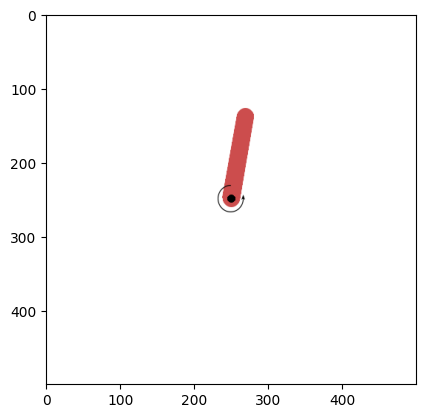

-7.952800418537099

In [9]:
student.test(play=True)